# **PERSIAPAN DATASET**

In [ ]:
!pip install pandas
import pandas as pd
from google.colab import drive
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
!pip install datasets transformers torch accelerate
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EncoderDecoderModel
from transformers import pipeline
!pip install torch torchvision torchaudio
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import TrainingArguments, Trainer


# # Mount Google Drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/drive


In [ ]:
# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
train_df = pd.read_csv('drive/MyDrive/summarization_dataset/liputan6-train-50k.csv')
test_df = pd.read_csv('drive/MyDrive/summarization_dataset/liputan6-xtreme-test.csv')
dev_df = pd.read_csv('drive/MyDrive/summarization_dataset/liputan6-xtreme-dev.csv')

In [ ]:
train_df

,id,url,clean_article,clean_summary,extractive_summary
0,100000,https://www.liputan6.com/news/read/100000/yudh...,Presiden Susilo Bambang Yudhoyono menekankan b...,"Menurut Presiden Susilo Bambang Yudhoyono, kem...","[0, 1]"
1,100002,https://www.liputan6.com/news/read/100002/jepa...,Perdana Menteri Jepang Junichiro Koizumi memin...,Pada masa silam Jepang terlalu ambisius untuk ...,"[2, 3]"
2,100003,https://www.liputan6.com/news/read/100003/pulu...,Banjir dengan ketinggian dua meter di Kabupate...,Puluhan hektare areal persawahan yang sebagian...,"[1, 5]"
3,100004,https://www.liputan6.com/news/read/100004/pres...,Presiden Susilo Bambang Yudhoyono menggelar pe...,Sekjen PBB Kofi Annan memuji langkah Presiden ...,"[2, 5]"
4,100005,https://www.liputan6.com/news/read/100005/warg...,"Warga Kampung Batu Dalam, Kecamatan Danau Kemb...",Untuk mempercepat pelaksanaan belajar-mengajar...,"[0, 2]"
...,...,...,...,...,...
49995,171127,https://www.liputan6.com/news/read/171127/agus...,"Setelah buron selama satu pekan, tersangka pem...","Setelah buron selama satu pekan, tersangka pem...","[0, 3]"
49996,171128,https://www.liputan6.com/news/read/171128/poli...,Petugas Kepolisian Resor Majene dan Polewali M...,"Polisi dan warga Pulau Battoa, Polewali Mandar...","[0, 5]"
49997,171129,https://www.liputan6.com/news/read/171129/meny...,Brigadir Polisi Dua Solahuddin atau Wibi yang ...,Seorang polisi di Pangkalpinang ditangkap kare...,"[1, 2]"
49998,171130,https://www.liputan6.com/news/read/171130/kons...,Dua pegawai negeri sipil di lingkungan Pemerin...,Dua PNS di lingkungan Pemkab Ngawi diringkus p...,"[0, 2]"


In [ ]:
dev_df

,id,url,clean_article,clean_summary,extractive_summary
0,1,https://www.liputan6.com/news/read/1/batas-pen...,Pemerintah masih memberikan waktu dua minggu l...,Pemerintah memberikan tenggat 14 hari kepada p...,"[1, 8]"
1,1000,https://www.liputan6.com/news/read/1000/lagi--...,Aksi peledakan kantor pemerintah di Aceh terny...,Peledakan bom kembali terjadi di Aceh. Kali in...,"[2, 5]"
2,10004,https://www.liputan6.com/news/read/10004/kenai...,Badan Kepegawaian Negara meminta pemerintah se...,Kenaikan gaji PNS belum bisa direalisasikan ka...,"[4, 5]"
3,10008,https://www.liputan6.com/news/read/10008/miran...,Komisi Pemeriksa Kekayaan Pejabat Negara ( KPK...,Deputi Gubernur Bank Indonesia Miranda Goeltom...,"[0, 1]"
4,10010,https://www.liputan6.com/news/read/10010/hasba...,Pemerintah menyelesaikan konflik di Aceh secar...,Sejumlah elemen masyarakat Aceh menentang pemb...,"[3, 13]"
...,...,...,...,...,...
4943,998,https://www.liputan6.com/news/read/998/pengung...,Akibat lingkungan yang buruk serta kesehatan y...,Tiga di antara puluhan ribu pengungsi Sambas d...,"[1, 8]"
4944,9987,https://www.liputan6.com/news/read/9987/mencur...,"Lamsira, seorang aparat keamanan, Kamis ( 22/3...",Seorang aparat keamanan nekat mencuri sepeda m...,"[1, 5, 11]"
4945,9990,https://www.liputan6.com/news/read/9990/try-su...,Mantan Wakil Presiden Try Sutrisno diperiksa s...,Mantan Wapres Try Sutrisno kembali diperiksa K...,"[0, 1]"
4946,9991,https://www.liputan6.com/news/read/9991/kejagu...,Mantan Wakil Komisaris Bank Umum Nasional Kaha...,Kejaksaan Agung mengeluarkan surat penahanan a...,"[2, 3]"


In [ ]:
test_df

,id,url,clean_article,clean_summary,extractive_summary
0,13020,https://www.liputan6.com/news/read/13020/bi-di...,Bank Indonesia dinilai masih akan menghadapi s...,Kendati Bank Sentral AS menurunkan suku bungan...,"[0, 4]"
1,13024,https://www.liputan6.com/news/read/13024/perub...,Penghapusan beberapa pasal menyangkut hak buru...,"Revisi Kepmennaker Nomor 78 Tahun 2001, dinila...","[0, 8]"
2,13025,https://www.liputan6.com/news/read/13025/puluh...,Operasi Sadar Jaya yang dilancarkan Selasa ( 1...,Polisi menangkap 32 pengunjung Diskotik Mileni...,"[2, 3]"
3,13027,https://www.liputan6.com/news/read/13027/ruu-p...,Sejumlah pasal dalam Rancangan Undang-undang P...,Praktisi penyiaran menyoroti sejumlah pasal da...,"[1, 7]"
4,13030,https://www.liputan6.com/news/read/13030/pusat...,Pusat desa kerajinan atau Pasar Kriya Desa Kas...,"Karena ditinggalkan para perajin, kondisi Desa...","[5, 6]"
...,...,...,...,...,...
3857,26379,https://www.liputan6.com/news/read/26379/keama...,Kepolisian Daerah Sumatra Utara meningkatkan k...,"Ratusan polisi mengamankan Medan, Sumatra Utar...","[0, 1]"
3858,26386,https://www.liputan6.com/news/read/26386/mengh...,"Bahar, korban ledakan bom di Asrama Haji Sudia...","Dianggap mengetahui kasus ledakan bom, Bahar m...","[2, 5]"
3859,26396,https://www.liputan6.com/news/read/26396/ratus...,Kendati masih ada larangan mendaki di Gunung M...,"Ratusan pendaki menaiki puncak Gunung Merapi, ...","[0, 5]"
3860,26398,https://www.liputan6.com/news/read/26398/dpp-p...,Dewan Pimpinan Pusat Partai Bulan Bintang meni...,"Sepanjang tahun 2001, kinerja pemerintah dinil...","[0, 8]"


# **DATA PREPROCESSING**

In [ ]:
train_df = train_df.drop(['id', 'url', 'extractive_summary'], axis=1)
dev_df = dev_df.drop(['id', 'url', 'extractive_summary'], axis=1)
test_df = test_df.drop(['id', 'url', 'extractive_summary'], axis=1)

In [ ]:
# rename the column "clean_article" into "original_text"
train_df = train_df.rename(columns={"clean_article": "original_text"})
train_df = train_df.rename(columns={"clean_summary": "abstractive_summary"})

dev_df = dev_df.rename(columns={"clean_article": "original_text"})
dev_df = dev_df.rename(columns={"clean_summary": "abstractive_summary"})

test_df = test_df.rename(columns={"clean_article": "original_text"})
test_df = test_df.rename(columns={"clean_summary": "abstractive_summary"})

In [ ]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)


(50000, 2)
(4948, 2)
(3862, 2)


In [ ]:
def clean_text(text):
    # Remove URL + lowercase
    text = re.sub(r'#(\w+)', lambda match: ' ' + re.sub(r'(?<=[a-z0-9])(?=[A-Z])', ' ', match.group(1)), text)
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the function to create new columns
train_df['original_text'] = train_df['original_text'].apply(clean_text)
train_df['abstractive_summary'] = train_df['abstractive_summary'].apply(clean_text)

dev_df['original_text'] = dev_df['original_text'].apply(clean_text)
dev_df['abstractive_summary'] = dev_df['abstractive_summary'].apply(clean_text)

test_df['original_text'] = test_df['original_text'].apply(clean_text)
test_df['abstractive_summary'] = test_df['abstractive_summary'].apply(clean_text)


# **Remove outlier based on text length**

### **Data Train**

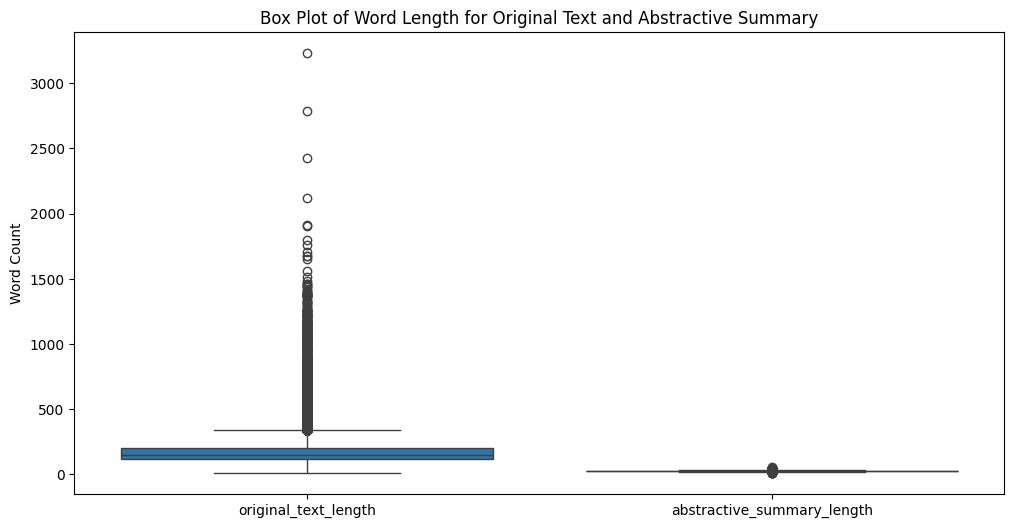

In [ ]:
plt.figure(figsize=(12, 6))
train_df['original_text_length'] = train_df['original_text'].apply(lambda x: len(str(x).split()))
train_df['abstractive_summary_length'] = train_df['abstractive_summary'].apply(lambda x: len(str(x).split()))
# train_df['extractive_summary_length'] = train_df['extractive_summary'].apply(lambda x: len(str(x).split()))
# sns.boxplot(data=train_df[['original_text_length', 'abstractive_summary_length', 'extractive_summary_length']])
sns.boxplot(data=train_df[['original_text_length', 'abstractive_summary_length']])
# plt.title('Box Plot of Word Length for Original Text, Abstractive Summary, and Extractive Summary')
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary')
plt.ylabel('Word Count')
plt.show()


In [ ]:
# Hitung panjang kata
train_df['original_text_length'] = train_df['original_text'].apply(lambda x: len(str(x).split()))
train_df['abstractive_summary_length'] = train_df['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Calculate the IQR for each column
Q1_original_text = train_df['original_text_length'].quantile(0.25)
Q3_original_text = train_df['original_text_length'].quantile(0.75)
IQR_original_text = Q3_original_text - Q1_original_text
lower_bound_original_text = Q1_original_text - 1.5 * IQR_original_text
upper_bound_original_text = Q3_original_text + 1.5 * IQR_original_text

Q1_abstractive_summary = train_df['abstractive_summary_length'].quantile(0.25)
Q3_abstractive_summary = train_df['abstractive_summary_length'].quantile(0.75)
IQR_abstractive_summary = Q3_abstractive_summary - Q1_abstractive_summary
lower_bound_abstractive_summary = Q1_abstractive_summary - 1.5 * IQR_abstractive_summary
upper_bound_abstractive_summary = Q3_abstractive_summary + 1.5 * IQR_abstractive_summary

# Filter data to remove outliers
train_df_cleaned = train_df[
    train_df['original_text_length'].between(lower_bound_original_text, upper_bound_original_text) &
    train_df['abstractive_summary_length'].between(lower_bound_abstractive_summary, upper_bound_abstractive_summary)
]

# Verifikasi apakah outliers sudah dihapus
print(f"Jumlah data sebelum penghapusan outlier: {len(train_df)}")
print(f"Jumlah data setelah penghapusan outlier: {len(train_df_cleaned)}")


Jumlah data sebelum penghapusan outlier: 50000
Jumlah data setelah penghapusan outlier: 45385


<ipython-input-77-f4035a983f3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned['original_text_length'] = train_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
<ipython-input-77-f4035a983f3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned['abstractive_summary_length'] = train_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))


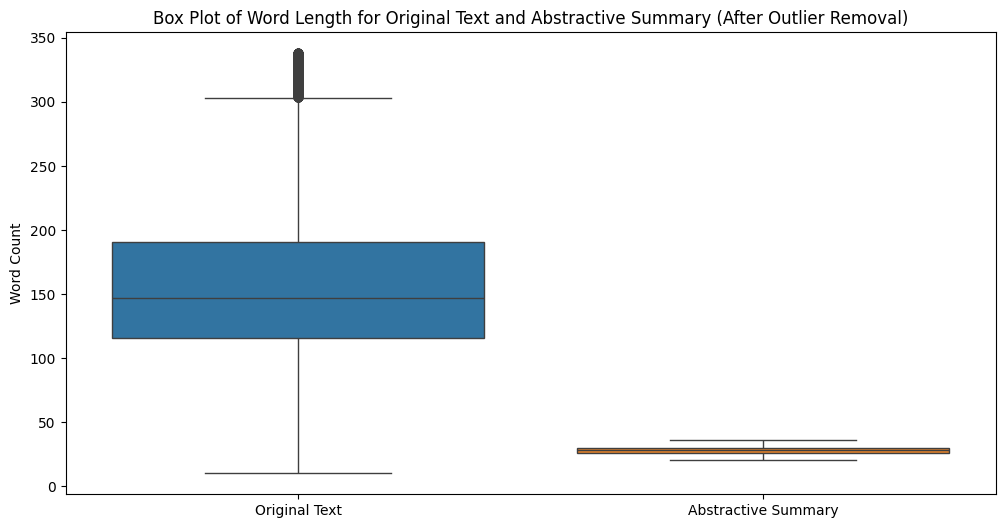

In [ ]:
# Hitung panjang kata setelah penghapusan outlier
train_df_cleaned['original_text_length'] = train_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
train_df_cleaned['abstractive_summary_length'] = train_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Visualisasi boxplot untuk panjang kata setelah penghapusan outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df_cleaned[['original_text_length', 'abstractive_summary_length']])

# Tambahkan judul dan label pada plot
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary (After Outlier Removal)')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Original Text', 'Abstractive Summary'], rotation=0)

# Tampilkan plot
plt.show()


### **DATA DEV**

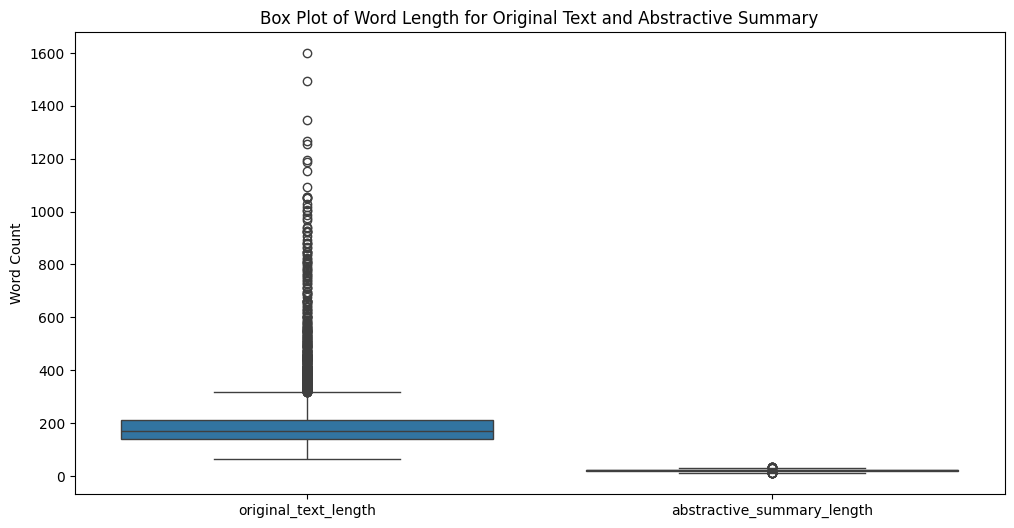

In [ ]:
plt.figure(figsize=(12, 6))
dev_df['original_text_length'] = dev_df['original_text'].apply(lambda x: len(str(x).split()))
dev_df['abstractive_summary_length'] = dev_df['abstractive_summary'].apply(lambda x: len(str(x).split()))
# train_df['extractive_summary_length'] = train_df['extractive_summary'].apply(lambda x: len(str(x).split()))
# sns.boxplot(data=train_df[['original_text_length', 'abstractive_summary_length', 'extractive_summary_length']])
sns.boxplot(data=dev_df[['original_text_length', 'abstractive_summary_length']])
# plt.title('Box Plot of Word Length for Original Text, Abstractive Summary, and Extractive Summary')
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary')
plt.ylabel('Word Count')
plt.show()

In [ ]:
# Hitung panjang kata
dev_df['original_text_length'] = dev_df['original_text'].apply(lambda x: len(str(x).split()))
dev_df['abstractive_summary_length'] = dev_df['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Calculate the IQR for each column
Q1_original_text = dev_df['original_text_length'].quantile(0.25)
Q3_original_text = dev_df['original_text_length'].quantile(0.75)
IQR_original_text = Q3_original_text - Q1_original_text
lower_bound_original_text = Q1_original_text - 1.5 * IQR_original_text
upper_bound_original_text = Q3_original_text + 1.5 * IQR_original_text

Q1_abstractive_summary = dev_df['abstractive_summary_length'].quantile(0.25)
Q3_abstractive_summary = dev_df['abstractive_summary_length'].quantile(0.75)
IQR_abstractive_summary = Q3_abstractive_summary - Q1_abstractive_summary
lower_bound_abstractive_summary = Q1_abstractive_summary - 1.5 * IQR_abstractive_summary
upper_bound_abstractive_summary = Q3_abstractive_summary + 1.5 * IQR_abstractive_summary

# Filter data to remove outliers
dev_df_cleaned = dev_df[
    dev_df['original_text_length'].between(lower_bound_original_text, upper_bound_original_text) &
    dev_df['abstractive_summary_length'].between(lower_bound_abstractive_summary, upper_bound_abstractive_summary)
]

# Verifikasi apakah outliers sudah dihapus
print(f"Jumlah data sebelum penghapusan outlier: {len(dev_df)}")
print(f"Jumlah data setelah penghapusan outlier: {len(dev_df_cleaned)}")


Jumlah data sebelum penghapusan outlier: 4948
Jumlah data setelah penghapusan outlier: 4555


<ipython-input-82-f8ad2d4cba1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df_cleaned['original_text_length'] = dev_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
<ipython-input-82-f8ad2d4cba1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df_cleaned['abstractive_summary_length'] = dev_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))


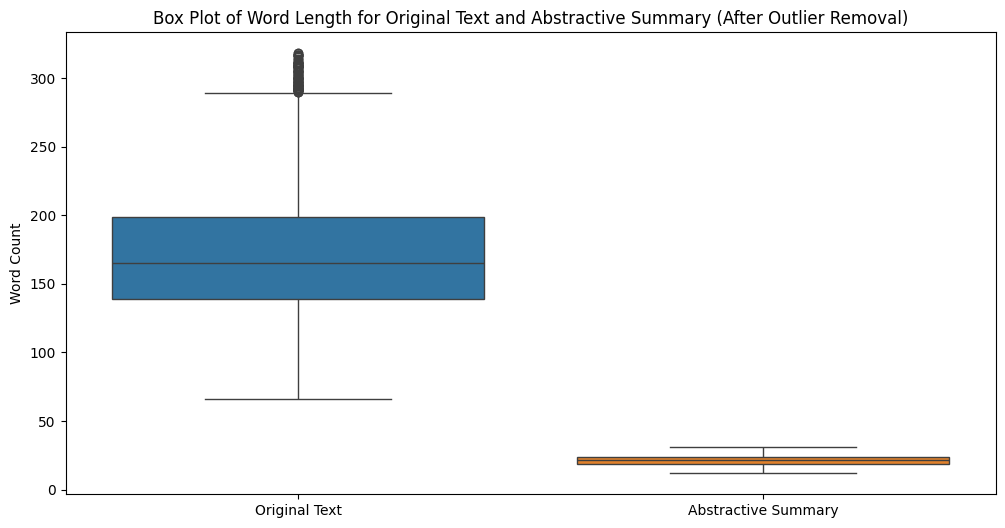

In [ ]:
# Hitung panjang kata setelah penghapusan outlier
dev_df_cleaned['original_text_length'] = dev_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
dev_df_cleaned['abstractive_summary_length'] = dev_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Visualisasi boxplot untuk panjang kata setelah penghapusan outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=dev_df_cleaned[['original_text_length', 'abstractive_summary_length']])

# Tambahkan judul dan label pada plot
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary (After Outlier Removal)')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Original Text', 'Abstractive Summary'], rotation=0)

# Tampilkan plot
plt.show()


### **Data Tes**

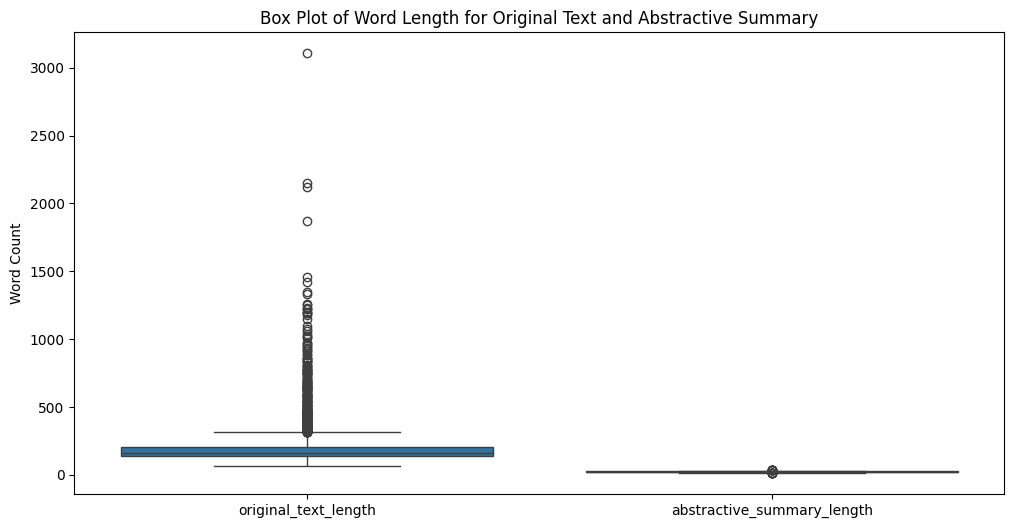

In [ ]:
plt.figure(figsize=(12, 6))
test_df['original_text_length'] = test_df['original_text'].apply(lambda x: len(str(x).split()))
test_df['abstractive_summary_length'] = test_df['abstractive_summary'].apply(lambda x: len(str(x).split()))
# train_df['extractive_summary_length'] = train_df['extractive_summary'].apply(lambda x: len(str(x).split()))
# sns.boxplot(data=train_df[['original_text_length', 'abstractive_summary_length', 'extractive_summary_length']])
sns.boxplot(data=test_df[['original_text_length', 'abstractive_summary_length']])
# plt.title('Box Plot of Word Length for Original Text, Abstractive Summary, and Extractive Summary')
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary')
plt.ylabel('Word Count')
plt.show()

In [ ]:
# Hitung panjang kata
test_df['original_text_length'] = test_df['original_text'].apply(lambda x: len(str(x).split()))
test_df['abstractive_summary_length'] = test_df['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Calculate the IQR for each column
Q1_original_text = test_df['original_text_length'].quantile(0.25)
Q3_original_text = test_df['original_text_length'].quantile(0.75)
IQR_original_text = Q3_original_text - Q1_original_text
lower_bound_original_text = Q1_original_text - 1.5 * IQR_original_text
upper_bound_original_text = Q3_original_text + 1.5 * IQR_original_text

Q1_abstractive_summary = test_df['abstractive_summary_length'].quantile(0.25)
Q3_abstractive_summary = test_df['abstractive_summary_length'].quantile(0.75)
IQR_abstractive_summary = Q3_abstractive_summary - Q1_abstractive_summary
lower_bound_abstractive_summary = Q1_abstractive_summary - 1.5 * IQR_abstractive_summary
upper_bound_abstractive_summary = Q3_abstractive_summary + 1.5 * IQR_abstractive_summary

# Filter data to remove outliers
test_df_cleaned = test_df[
    test_df['original_text_length'].between(lower_bound_original_text, upper_bound_original_text) &
    test_df['abstractive_summary_length'].between(lower_bound_abstractive_summary, upper_bound_abstractive_summary)
]

# Verifikasi apakah outliers sudah dihapus
print(f"Jumlah data sebelum penghapusan outlier: {len(test_df)}")
print(f"Jumlah data setelah penghapusan outlier: {len(test_df_cleaned)}")


Jumlah data sebelum penghapusan outlier: 3862
Jumlah data setelah penghapusan outlier: 3555


<ipython-input-84-94052e420887>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cleaned['original_text_length'] = test_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
<ipython-input-84-94052e420887>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df_cleaned['abstractive_summary_length'] = test_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))


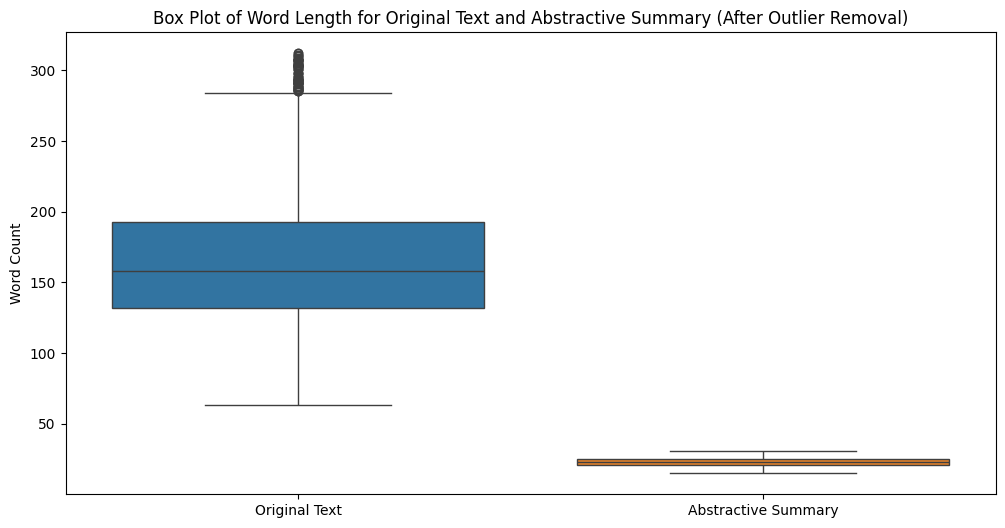

In [ ]:
# Hitung panjang kata setelah penghapusan outlier
test_df_cleaned['original_text_length'] = test_df_cleaned['original_text'].apply(lambda x: len(str(x).split()))
dev_df_cleaned['abstractive_summary_length'] = test_df_cleaned['abstractive_summary'].apply(lambda x: len(str(x).split()))

# Visualisasi boxplot untuk panjang kata setelah penghapusan outlier
plt.figure(figsize=(12, 6))
sns.boxplot(data=test_df_cleaned[['original_text_length', 'abstractive_summary_length']])

# Tambahkan judul dan label pada plot
plt.title('Box Plot of Word Length for Original Text and Abstractive Summary (After Outlier Removal)')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['Original Text', 'Abstractive Summary'], rotation=0)

# Tampilkan plot
plt.show()


## **Donwload dataset after outlier**

In [ ]:
train_df_cleaned = train_df_cleaned.drop(['original_text_length', 'abstractive_summary_length'], axis=1)
dev_df_cleaned = dev_df_cleaned.drop(['original_text_length', 'abstractive_summary_length'], axis=1)
test_df_cleaned = test_df_cleaned.drop(['original_text_length', 'abstractive_summary_length'], axis=1)

In [ ]:
train_df_cleaned.to_csv('train_df_cleaned.csv', encoding = 'utf-8-sig')
dev_df_cleaned.to_csv('dev_df_cleaned.csv', encoding = 'utf-8-sig')
test_df_cleaned.to_csv('test_df_cleaned.csv', encoding = 'utf-8-sig')

files.download('train_df_cleaned.csv')
files.download('dev_df_cleaned.csv')
files.download('test_df_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Load Cleaned Data**

In [ ]:
train_df = pd.read_csv("drive/MyDrive/summarization_dataset/train_df_cleaned.csv")
dev_df = pd.read_csv("drive/MyDrive/summarization_dataset/dev_df_cleaned.csv")
tes_df=pd.read_csv("drive/MyDrive/summarization_dataset/test_df_cleaned.csv")

In [ ]:
# Basic overview
print('data train')
print(train_df.shape)
print(train_df.info())
print(train_df.isnull().sum())

print('\ndata dev')
print(dev_df.shape)
print(dev_df.info())
print(dev_df.isnull().sum())

print('\ntes data')
print(tes_df.shape)
print(tes_df.info())
print(tes_df.isnull().sum())

data train
(45385, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45385 entries, 0 to 45384
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           45385 non-null  int64 
 1   original_text        45385 non-null  object
 2   abstractive_summary  45385 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None
Unnamed: 0             0
original_text          0
abstractive_summary    0
dtype: int64

data dev
(4555, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555 entries, 0 to 4554
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           4555 non-null   int64 
 1   original_text        4555 non-null   object
 2   abstractive_summary  4555 non-null   object
dtypes: int64(1), object(2)
memory usage: 106.9+ KB
None
Unnamed: 0             0
original_text          0
abst

In [ ]:

# Load pre-trained T5 model for text summarization
model_name = "cahya/t5-base-indonesian-summarization-cased"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
tes_dataset = Dataset.from_pandas(tes_df)

In [ ]:
def preprocess_function_abstractive(examples):

    abstractive_summary = [
        " ".join(summary) if isinstance(summary, list) else summary
        for summary in examples["abstractive_summary"]
    ]  # List comprehension for handling list summaries

    # Tokenize the text input
    model_inputs = tokenizer(
        examples["original_text"], max_length=512, truncation=True, padding="max_length"
    )

    # Tokenize the combined summary (labels)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            abstractive_summary, max_length=256, truncation=True, padding="max_length"
        )

    # Add the tokenized labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Apply preprocessing to the train and dev datasets
tokenized_train_datasets = train_dataset.map(preprocess_function_abstractive, batched=True)
tokenized_dev_datasets = dev_dataset.map(preprocess_function_abstractive, batched=True)

Map:   0%|          | 0/45385 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4555 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_datasets)

Dataset({
    features: ['Unnamed: 0', 'original_text', 'abstractive_summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 45385
})


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,
    push_to_hub=False,
    fp16=True,
    save_steps=500,           # Save the model every 500 steps
    eval_steps=500,           # Evaluate every 500 steps
    logging_dir="./logs",     # Directory for logs
    logging_steps=100,        # Log every 100 steps
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install datasets evaluate
!pip install rouge_score
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=53108c60b5f46626e89d13be3d6d4dd595dfe5f57cafb27e7bd75ba1d5ba3f50
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
# Define data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# # Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,  # Use tokenized train dataset
    eval_dataset=tokenized_dev_datasets,     # Use tokenized dev dataset for validation
    data_collator=data_collator,
)

# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.247400,0.319865
2,0.234800,0.316997
3,0.226900,0.317440


TrainOutput(global_step=17022, training_loss=0.2508146040112694, metrics={'train_runtime': 3359.6926, 'train_samples_per_second': 40.526, 'train_steps_per_second': 5.067, 'total_flos': 8.29126615891968e+16, 'train_loss': 0.2508146040112694, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.31744036078453064, 'eval_runtime': 32.0566, 'eval_samples_per_second': 142.092, 'eval_steps_per_second': 17.781, 'epoch': 3.0}


In [ ]:
import os

# Define the path in Google Drive where you want to save the model
output_dir = '/content/drive/MyDrive/summarization_dataset/T5:Abstractive'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to /content/drive/MyDrive/summarization_dataset/T5:Abstractive


**EVALUASI dev_df**

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the trained model and tokenizer from the saved directory
model_name = "/content/drive/MyDrive/summarization_dataset/T5:Abstractive"  # Ganti dengan direktori model yang sudah disimpan
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)



**Evaluasi tes_df**

In [ ]:
# Evaluate the model on the test dataset
tokenized_test_datasets = tes_dataset.map(preprocess_function_abstractive, batched=True)

test_results = trainer.evaluate(eval_dataset=tokenized_test_datasets)
print("Test Evaluation Results:", test_results)

Map:   0%|          | 0/3555 [00:00<?, ? examples/s]

Test Evaluation Results: {'eval_loss': 0.31563544273376465, 'eval_runtime': 25.099, 'eval_samples_per_second': 141.639, 'eval_steps_per_second': 17.73, 'epoch': 3.0}


In [ ]:
import evaluate

# Load the ROUGE metric using evaluate
rouge_metric = evaluate.load("rouge")

# Function to compute ROUGE metrics
def compute_rouge_metrics(eval_dataset):
    predictions = []
    references = []

    # Loop through test dataset and generate summaries
    for example in eval_dataset:
        # Get the input text
        input_text = example["original_text"]

        # Preprocess and tokenize input text
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        inputs = {key: val.to(model.device) for key, val in inputs.items()}

        # Generate summary
        summary_ids = model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Append generated and reference summaries for evaluation
        predictions.append(generated_summary)
        references.append(example["abstractive_summary"])

    # Compute ROUGE score
    results = rouge_metric.compute(predictions=predictions, references=references)
    return results

# Compute ROUGE for tokenized test datasets
rouge_results = compute_rouge_metrics(tokenized_test_datasets)
print("ROUGE Evaluation Results:", rouge_results)


ROUGE Evaluation Results: {'rouge1': 0.3424545719941174, 'rouge2': 0.14246621625749356, 'rougeL': 0.2648394976547842, 'rougeLsum': 0.26483782873537287}


In [ ]:
# Example of inference with preprocessing
test_text = """presiden susilo bambang yudhoyono menekankan bahwa tantangan terbesar yang dihadapi bangsa bangsa asia dan afrika saat ini
adalah masalah kemiskinan yang sangat buruk yudhoyono berharap masalah ini menjadi pembahasan penting dalam konferensi tingkat tinggi asia afrika
 demikian pidato yudhoyono saat membuka ktt asia afrika di jakarta convention centre jakarta jumat 22 4 baca presiden yudhoyono resmi membuka kaa
 pada awal pidatonya yudhoyono para peserta untuk mengheningkan cipta sejenak bagi korban gempa dan tsunami di nanggroe aceh darussalam dan nias
 sumatra utara selanjutnya yudhoyono menegaskan pertemuan ini bukanlah sekadar romantisme tetapi upaya bersama untuk memecahkan masalah yang
 dihadapi kedua benua acara pembukaan konferensi ini juga dihadiri sekretaris jenderal perserikatan bangsa bangsa kofi annan yang datang sebagai
 tamu kehormatan meski fokusnya adalah mempererat hubungan antara asia dan afrika konferensi ini dipastikan akan diwarnai sejumlah pertemuan bilateral ktt
 asia afrika akan berlangsung selama dua hari kegiatan ini akan diakhiri dengan acara napak tilas ke kota bandung jawa barat tempat berlangsungnya konferensi
 asia afrika pada 1955 sementara itu para istri kepala negara yang hadir di peringatan emas kaa mengikuti ladies program yang disuguhkan ibu negara nyonya
 ani yudhoyono acara gelar budaya indonesia ini berlangsung di sasono langen budoyo taman mini indonesia indah jakarta timur kegiatan yang dimulai sekitar
 pukul 10 30 wib ini diawali dengan tarian dan atraksi selamat datang reog ponorogo ibu ani menyalami satu per satu ibu negara dari 28 negara peserta yang
 datang kemudian dilanjutkan dengan acara foto bersama dalam sambutannya ibu ani berharap agar semangat kaa semakin mempererat hubungan antarbangsa di benua
 asia dan afrika selanjutnya ibu negara dan para tamu menyaksikan peragaan busana dari tiga perancang busana indonesia yakni
ramli adjie notonegoro dan afif syakur kunjungan ke beberapa anjungan yang ada di tmii juga dilakukan awd ali rojihi dan teguh dwi hartono"""

# Preprocess the input text
preprocessed_text = clean_text(test_text)

# Tokenize the preprocessed text
inputs = tokenizer(preprocessed_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
inputs = {key: val.to(model.device) for key, val in inputs.items()}

# Generate the summary
summary_ids = model.generate(inputs["input_ids"], max_length=256, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Text:", test_text)
print("Preprocessed Text:", preprocessed_text)
print("Generated Summary:", summary)


Original Text: presiden susilo bambang yudhoyono menekankan bahwa tantangan terbesar yang dihadapi bangsa bangsa asia dan afrika saat ini
adalah masalah kemiskinan yang sangat buruk yudhoyono berharap masalah ini menjadi pembahasan penting dalam konferensi tingkat tinggi asia afrika
 demikian pidato yudhoyono saat membuka ktt asia afrika di jakarta convention centre jakarta jumat 22 4 baca presiden yudhoyono resmi membuka kaa
 pada awal pidatonya yudhoyono para peserta untuk mengheningkan cipta sejenak bagi korban gempa dan tsunami di nanggroe aceh darussalam dan nias
 sumatra utara selanjutnya yudhoyono menegaskan pertemuan ini bukanlah sekadar romantisme tetapi upaya bersama untuk memecahkan masalah yang
 dihadapi kedua benua acara pembukaan konferensi ini juga dihadiri sekretaris jenderal perserikatan bangsa bangsa kofi annan yang datang sebagai
 tamu kehormatan meski fokusnya adalah mempererat hubungan antara asia dan afrika konferensi ini dipastikan akan diwarnai sejumlah pertemua